[[       -inf        -inf        -inf        -inf  0.        ]
 [       -inf        -inf        -inf        -inf  0.        ]
 [       -inf        -inf        -inf        -inf  0.        ]
 [       -inf        -inf        -inf        -inf  0.        ]
 [       -inf        -inf        -inf        -inf  0.        ]
 [       -inf        -inf        -inf        -inf  0.        ]
 [       -inf        -inf        -inf        -inf  0.        ]
 [       -inf        -inf        -inf        -inf  0.        ]
 [       -inf        -inf        -inf        -inf  0.        ]
 [       -inf        -inf        -inf        -inf  0.        ]
 [       -inf        -inf        -inf        -inf  0.        ]
 [       -inf        -inf        -inf        -inf  0.        ]
 [       -inf        -inf        -inf        -inf  0.        ]
 [       -inf        -inf        -inf        -inf  0.        ]
 [       -inf        -inf        -inf        -inf  0.        ]
 [       -inf        -inf        -inf        -inf  0.  

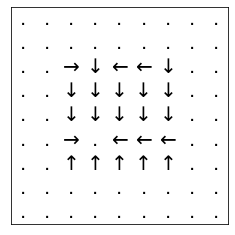

In [15]:
import numpy as np
from enum import Enum
from typing import NewType, List, Tuple
from itertools import product
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

# 0 - prazno polje
# 2 - kraj
# 3 - provalija

# Agent u svakom polju moze da odabere potez: gore, dole, levo, desno
# Sa verovatnocom Beta odlazi na bolje na koje je odabrao, a sa 1-Beta prokliza
# na sledece polje u odabranom pravcu.
# Ako ispadne sa table dobija nagradu -1
# Ako dodje do polja sa oznakom 2, dobija nagradu +1
# Za sva ostala polja, nagrada je 0.


env = np.array([
    [3,3,3,3,3,3,3,3,3],
    [3,3,3,3,3,3,3,3,3],
    [3,3,0,0,0,0,0,3,3],
    [3,3,0,0,0,0,0,3,3],
    [3,3,0,0,0,0,0,3,3],
    [3,3,0,2,0,0,0,3,3],
    [3,3,0,0,0,0,0,3,3],
    [3,3,3,3,3,3,3,3,3],
    [3,3,3,3,3,3,3,3,3]
])

class Actions(Enum):
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3
    STAY = 4
    
action_move = np.array([
    [-1, 0], 
    [1,0], 
    [0,-1], 
    [0,1], 
    [0,0]
])
    
    
Probability = NewType('Probability', float)
Reward = NewType('Reward', float)
State = NewType('State', int)

Beta = 0.8
def state_to_coords(index: State) -> (int, int):
    return tuple(np.unravel_index(index, env.shape))

def coords_to_state(coords: (int, int)) -> State:
    return np.ravel_multi_index(coords, env.shape)

def possible_actions(s: State) -> List[Actions]:
    coords = state_to_coords(s)
    if env[coords] == 3 or env[coords] == 2:
        return [Actions.STAY]
    else:
        return [Actions.UP, Actions.DOWN, Actions.LEFT, Actions.RIGHT]
   
def possible_states(s: State, a: Actions) -> List[Tuple[State, Probability]]:
    s_coord = state_to_coords(s)
    if env[s_coord] == 2 or env[s_coord] == 3:
        return [(coords_to_state(s_coord), 1.0)]
    move = action_move[a.value]
    adj = (s_coord[0] + move[0], s_coord[1] + move[1])
    adj_slip = (adj[0] + move[0], adj[1] + move[1])
    return [(coords_to_state(adj), Beta), (coords_to_state(adj_slip), 1 - Beta)]

T = np.zeros(shape=(env.size, len(Actions), env.size))
for s in range(env.size):
    for a in possible_actions(s):
        for (sp, prob) in possible_states(s, a):
            T[s][a.value][sp] = prob
      
def R(s: State, a: Actions, sp: State) -> Reward:
    s_coords = state_to_coords(s)
    sp_coords = state_to_coords(sp)
    if env[s_coords] == 0 and env[sp_coords] == 3:
        return -1
    if env[s_coords] == 0 and env[sp_coords] == 2:
        return 1
    return 0
    

gamma = 0.98
Q_values = np.full((env.size, len(Actions)), -np.inf)
for state in range(env.size):
    for action in possible_actions(state):
        Q_values[state, action.value] = 0.0
        

num_of_iterations = 4000
for iteration in range(num_of_iterations):
    Q_prev = Q_values.copy()
    for s in range(env.size):
        for a in possible_actions(s):
            Q_values[s, a.value] = np.sum([
                T[s][a.value][sp]*(R(s, a, sp) + gamma * np.max(Q_prev[sp]))
                for (sp, _) in possible_states(s, a)
            ])
            
print(Q_values)
print(np.argmax(Q_values, axis=1)) # optimalna akcija u svakom stanju
optimal_action_in_state = np.argmax(Q_values, axis=1).reshape(env.shape) 

fig, ax = plt.subplots()
n = optimal_action_in_state.shape[0]
m = optimal_action_in_state.shape[1]

ax.set_xlim(0, n)
ax.set_ylim(0, m)

arrows = ['↑', '↓', '←', '→', '.']
ax.invert_yaxis()

for i in range(n):
    for j in range(m):
        ax.annotate(arrows[optimal_action_in_state[i,j]], xy=(j + 0.5, i + 0.5),
                    ha='center', va='center', fontsize=20)

ax.set_xticks([])
ax.set_yticks([])

ax.set_aspect('equal')

plt.show()